In [ ]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms


train_dict = {}

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")
    print("Using CPU")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [ ]:
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

In [ ]:
def load_data(data_type):
    X, y = [], []
    dataset_path = "fashion_mnist_images/" + data_type
    classes = os.listdir(dataset_path)
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                img_path = os.path.join(class_path, img)
                image = Image.open(img_path).convert('L')
                X.append(transform(image))
                y.append(int(class_name))
    return TensorDataset(torch.stack(X), torch.tensor(y))

In [ ]:
train_dataset = load_data(data_type='train')
test_dataset = load_data(data_type='test')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
EPOCHS = 2
BATCH_SIZE = 32
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def train():
    for epoch in range(EPOCHS):
        train_dict[epoch] = {}
        net.train()
        for step, (images, labels) in enumerate(tqdm(train_loader)):
            train_dict[epoch][step] = {}
            X = images.to(device)
            y = labels.to(device)

            optimizer.zero_grad()
            outputs = net(X)
            loss = loss_function(outputs, y) 
            loss.backward()
            optimizer.step()

            for n, layer in enumerate(net.modules()):  
                if isinstance(layer, nn.Linear):
                    train_dict[epoch][step] = {}
                    train_dict[epoch][step]['weights'] = layer.weight.detach().cpu().clone()
                    train_dict[epoch][step]['biases'] = layer.bias.detach().cpu().clone()

        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

In [ ]:
train()

In [ ]:
def test():
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')

test()

In [ ]:
train_dict[0][1]['biases'].shape

In [ ]:
import pickle
with open("train_dict.pkl", "wb") as f:
    pickle.dump(train_dict, f)

tensor(2)
PREDICTION: 2


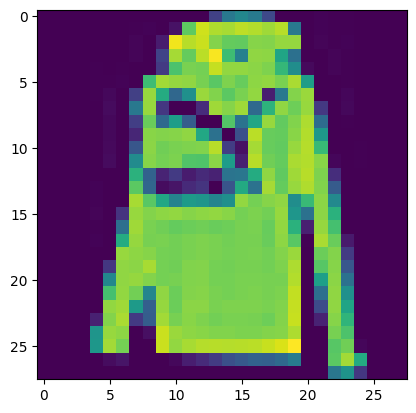

In [325]:
import matplotlib.pyplot as plt

for (images, label) in (test_loader):
    print(label[0])
    img = images[0]
    images = images.to(device)
    preds = net(images)
    print(f"PREDICTION: { torch.argmax(preds[0]) }")
    plt.imshow(img.reshape(28, 28))
    break

In [317]:
# for n, layer in enumerate(net.modules()):
#     if True:
#         print(f"=============START==={n}============")
#         print(f"Layer {n}: {layer}")


#         # print("=============================")
#         # if hasattr(layer, 'parameters'):
#             for param_name, param in layer.named_parameters():
#                 print(f"    Parameter Name: {param_name}, Shape: {param.shape}")



#         print("=============================")
#         if hasattr(layer, 'children'):
#             for child_n, child_layer in enumerate(layer.children()):
#                 print(f"  Child Layer {child_n}: {child_layer}")



#         #print("=============================")
#         # Example of accessing a specific attribute (if it exists)
#         if hasattr(layer, 'some_attribute'):
#             print(f"  some_attribute: {getattr(layer, 'some_attribute')}")



#         print("=============================")
#         for param_name, param in layer.named_parameters():
#             print(param.shape)

In [333]:
for params in net.parameters():
    if len(params.shape) == 2:
        print(params.shape, params.sum(axis=1).shape)

torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 32]) torch.Size([32])
torch.Size([10, 32]) torch.Size([10])


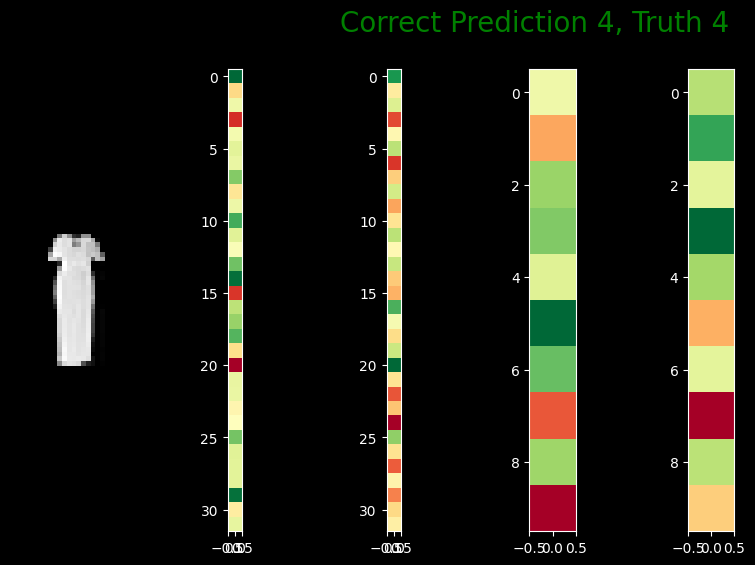

In [388]:
from matplotlib import style

style.use("dark_background")

def visualize_layers(sample_num, fig):
    for (images, label) in (test_loader):
        output_truth = label[sample_num]
        input_data = images[sample_num]

        images = images.to(device)
        outputs = net(images)

        prediction = torch.argmax(outputs[sample_num])

        if prediction == output_truth:
            title_text = f"Correct Prediction { prediction+1 }, Truth { output_truth+1 }"
            fig.suptitle(title_text, fontsize=20, color='g')
        else: 
            title_text = f"Wrong Prediction { prediction+1 }, Truth { output_truth+1 }"
            fig.suptitle(title_text, fontsize=20, color='r')


        ax0 = plt.subplot2grid((1, 7), (0, 0), rowspan=1, colspan=1)
        ax1 = plt.subplot2grid((1, 7), (0, 1), rowspan=1, colspan=1)
        ax2 = plt.subplot2grid((1, 7), (0, 2), rowspan=1, colspan=1)
        ax3 = plt.subplot2grid((1, 7), (0, 3), rowspan=1, colspan=1)
        ax4 = plt.subplot2grid((1, 7), (0, 4), rowspan=1, colspan=1)

        layers = []

        for params in net.parameters():
            if len(params.shape) == 2:
                layers.append([params.sum(axis=1).detach().cpu().numpy()])
        
        layers.append([outputs[sample_num].detach().cpu().numpy()])

        layer_1 = np.rot90(layers[0], k=3, axes=(0, 1))
        layer_2 = np.rot90(layers[1], k=3, axes=(0, 1))
        layer_3 = np.rot90(layers[2], k=3, axes=(0, 1))
        layer_4 = np.rot90(layers[3], k=3, axes=(0, 1))


        ax0.imshow(input_data.reshape(28, 28), cmap='gray')

        ax1.imshow(layer_1, cmap="RdYlGn")
        ax2.imshow(layer_2, cmap="RdYlGn")
        ax3.imshow(layer_3, cmap="RdYlGn")
        ax4.imshow(layer_4, cmap="RdYlGn")

        ax0.axis("off")
        
        break

fig = plt.figure(figsize=(14, 6))
visualize_layers(0, fig)